<span style='font-family:"Times New Roman"'> <span style='font-size:20px'>
# <center>Shake Table Analysis Using Machine Learning Example: Linear Regression</center>
<br>
<br>
<center>Kayla Erler$^{1}$, Anirudha Agrawal$^{2}$, and Gilberto Mosqueda$^{1}$<center>
<br>
*<center>$^1$Department of Structural Engineering, University of California, San Diego, CA, U.S.A.<center>*
*<center>$^2$Department of Data Science, University of California, San Diego, CA, U.S.A.<center>*
 <br>
<br>
<strong><center>SUMMARY<center></strong>
<br>
<br>
<div style="text-align: justify">
In this series of notebooks focused on machine learning applications for shake sable data, linear regression methods are explored. Linear regression is one of the most simple, straightforward, and commonly used methods available for structural engineers. The challenge with using linear regression for machine learning is that a set of features that are linearly related to the target is necessary to form a proper prediction (unlike some more advanced ML algorithms). The advantage is however, once these features and parameters are developed, the outcome is easily interpretable and replicable by others. Two approaches are available for this regression analysis use case. The first uses the sklearn implementation that provides a clean and simple approach. This powerful ML library also has many tools to perform things like feature selection and piece-wise linear regression. These tools can make finding the correct relationships linear and nonlinear a more streamlined process. The second implementation uses a neural network with PyTorch. The neural network has a significant disadvantage in the need to tune hyperparameters (the default values in this project have been tuned already). However, it comes with the advantage of being a more flexible implementation. This allows the user to modify the loss to address problems of class imbalance. Furthermore, it forms the basis for the network architecture that will be expanded to deeper learning models in future implementations.
<br>
<br>


## References and Licensing
This report examines data from the seismic response modification device (SRMD) empty table runs. More details on the testing facility can be found at the following link:
> • [Caltrans Seismic Response Modification Device (SRMD) Test Facility](https://se.ucsd.edu/facilities/laboratory-listing/srmd)

The data published in DesignSafe and can be found in the link below:
> • [TBD] currently included in this directory

Refferences for the papers used to facilitate developement of the models in this project can be found at the following links:
> • [Shortreed et al. (2001)](https://royalsocietypublishing.org/doi/10.1098/rsta.2001.0875) "Characterization and testing of the Caltrans Seismic Response Modification Device Test System". Phil. Trans. R. Soc. A.359: 1829–1850
<br>
> • [Ozcelick et al. (2008)](http://jaguar.ucsd.edu/publications/refereed_journals/Ozcelik_Luco_Conte_Trombetti_Restrepo_EESD_2008.pdf) "Experimental Characterization, modeling and identification of the NEES-UCSD shake table mechanical systetm". Eathquake Engineering and Structural Dynamics, vol. 37, pp. 243-264, 2008



Citation and Licensing:
> •	[Erler et al. (2024 TBD)]
<br>
> •	[Rathje et al. (2017)](https://doi.org/10.1061/(ASCE)NH.1527-6996.0000246) "DesignSafe: New Cyberinfrastructure for Natural Hazards Engineering". ASCE: Natural Hazards Review / Volume 18 Issue 3 - August 2017
<br>
> •	This software is distributed under the [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.html).

## Prior Knowledge and Resources
This notebook is intended for users with some level of experience with python coding and a basic understanding of machine learning. Resources for these underlying principles are as follows:

1. [Introduction to Scientific Programming with Python](https://www.youtube.com/watch?v=ivZH9JUwvrc)

2. [An Example-Based Introduction to Common Machine Learning Approaches](https://www.designsafe-ci.org/rw/use-cases/#!#vantassel_and_zhang%2Fusecase%2F)

3. [Workshop on Artificial Intelligence in Natural Hazards Engineering](https://www.designsafe-ci.org/data/browser/public/designsafe.storage.published/PRJ-2767)

## Table of Contents
* [1. Introduction](#first-bullet)
* [2. Load and Install Python Libraries](#second-bullet)
* [3. Preprocess Data](#third-bullet)
* [4. Fit Physics Informed Neural Network](#fourth-bullet)
    * [4.1 Individual Hyperparameter Selection](#fourth1-bullet)
    * [4.2 Grid Search Hyperparameter Tuning](#fourth2-bullet)
    * [4.3 Model Testing and Saving](#fourth2-bullet)
* [5. Result Visualization](#fifth-bullet)
* [6. Conclusion](#sixth-bullet)

## 1. Introduction  <a class="anchor" id="first-bullet">
<div style="text-align: justify">
        <br>

## 2. Load and Install Python Libraries <a class="anchor" id="second-bullet">
The python libraries listed below need to be installed on the initial run with the currently activated server or every three days. All other libraries should be installed on the updated image for DesignSafe.

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!pip install --quiet scikit-learn
!pip3 install --quiet torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


The python libraries used in this notebook include the standard numpy and math libraries for working with data arrays. The scipy library is used for the signal processing. As well as pandas for reading in data from the included text files included in this project.

In [1]:
# python files created for this project
#import gdrive.MyDrive.structural.preprocess_data_v2 as preprocess_data_v2
#import gdrive.MyDrive.structural.ShortreedModel as ShortreedModel

# python files created for this project
import post_process
import preprocess_data

# Open source libraries available in python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.utils.data import Dataset

#in case underlying files need updating while the notebook is running
import importlib
importlib.reload(preprocess_data)

c:\Users\kayla\Documents\Research\DesignSafe\structural\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'preprocess_data' from 'c:\\Users\\kayla\\Documents\\Research\\DesignSafe\\structural\\preprocess_data.py'>

## 3. Preprocess Data <a class="anchor" id="third-bullet">
<div style="text-align: justify">
    The PreprocessingVisualization.ipynb notebook included with this project shows the underlying filter functions that are implemented here. All data is passed through this process for both models. The data is also normalized using z-score normalization. This normalization provides zero mean and unit standard deviation on a signal-wise basis. By default, the entire dataset is extracted from the ET_Runs folder, which contains 87 test runs. The available data contains signficant differences in run length. The reserved set for testing is seperated by number of points of the total dataset after the runs are randomized and concatenated rather than selecting specific runs for testing. This method was chosen over random selection between all points so as to allow for completely unseen data sets to exist in the testing set and to have the desired training to testing data point ratio. Correct preprocessing of the data set has been found to be one of the most significant and challenging components to proper model fitting.

    Run the following block to call the load_data_set function and save the parameters needed to inverse normalize.

*If using this code on the DesignSafe community data, it is not possible to save the preprocessed data to files as the user will not have writing permissions. Potential solutions if an alteration of the preprocessing is desired:
1. The user is welcome to download the notebooks to their own directory and change the source directory (Mpath) for data extraction from the current working directory to .......
2. Change the store_data variable to False so that the new preprocessing method is implemented without storing it

In [2]:
########## Select if data has previously been stored and if you'd like to store the data ###################
data_stored = False #enter False if you want to reprocess the data rather than using the current preprocessed
store_data  = True  #enter False if you are using in community data
normalize_data_set = True
importlib.reload(preprocess_data)

<module 'preprocess_data' from 'c:\\Users\\kayla\\Documents\\Research\\DesignSafe\\structural\\preprocess_data.py'>

In [3]:
# load data set from individual testing files or with preprocessed data
signals_test, signals_train_val, signals_train, signals_val, norm_params, force_SRMD_test = preprocess_data.load_data_set(data_stored, store_data, normalize_data_set, preprocessed_data_directory = "preprocessed_data_case3", signals_type= 4)

# normalization parameters to be used for result visualization
u, sd = norm_params
if normalize_data_set:
    y_norm_params       = (u[-1],sd[-1])
else:
    y_norm_params       = (u,sd)

(53965, 12)
(23965, 12)
(59915, 12)


KeyboardInterrupt: 

## 4. Physics Informed Neural Network <a class="anchor" id="fourth-bullet">
<div style="text-align: justify">
    description...

In [ ]:
class CustomDeepNeuralNetwork(nn.Module):
    """ Class that defines the neural network. This class is customizable in the sense that it takes input_size, output_size and
     hidden_neurons and activation function as input so basically one can customize the whole network based on these parameters.

    Inputs:
        input_size                 - the number of input features you want to pass to the neural network.
                                     Example: 5


        output_size                - the size of the prediction, note that this network is designed to have a linear layer in the end. This
                                      is a concious choice based on the problem statement
                                      Example: 1

        hidden_neurons             - this is an array, stating the neurons in each hidden layer of the neural network.
                                     Example: [30, 50, 100, 80, 40, 10], so this states that the first hidden layer has 30 neurons, second has 50 and so on.

        activation                 - this states the non linearity we want to introduce between each layer, as stated before the final activation is always linear.
                                     this is just between layers.
                                     Example: 'relu', 'sigmoid'

    Outputs: It will initialize a CustomDeepNeuralNetwork object for you

    """
    def __init__(self, input_size, output_size, hidden_neurons, activation):
        super(CustomDeepNeuralNetwork, self).__init__()

        layers = [input_size] + hidden_neurons + [output_size]
        self.hidden_layers = nn.ModuleList()


        for i in range(len(layers)- 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1])) # Creating the hidden layers from the array given as input
            nn.init.normal_(self.hidden_layers[i].weight, mean=0.0, std=0.1) # initializing the weights of each layer


        self.activation = self.get_activation(activation) # Setting the activation function

    def forward(self, x):
        for layer in self.hidden_layers[:-1]: # for every layer except the last layer
            x = layer(x) # Multiply from the weights of the layer
            x = self.activation(x) #Apply activation function

        return self.hidden_layers[-1](x) # Just multiply linearly for the layer output layer
# Defining all the activation function available for this class, one can add more if needed
    def get_activation(self, name):
        if name == 'relu':
            return nn.ReLU()
        elif name == 'sigmoid':
            return nn.Sigmoid()
        elif name == 'tanh':
            return nn.Tanh()
        elif name == 'softmax':
            return nn.Softmax(dim=1)
        elif name == 'exp':
            return  nn.ELU()
        else:
            raise ValueError(f"Invalid activation function: {name}")


In [ ]:
#Defining a custom dataset class according to how the signals are defined
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = torch.tensor(data[:, [0, 3, 4]], dtype=torch.float32).cuda()  # Load inputs as a tensor and move to CUDA
        self.targets = torch.tensor(data[:, 1], dtype=torch.float32).cuda()  # Load targets as a tensor and move to CUDA

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):

        if index>2 and index+3 < self.inputs.size(0):


          x2 = self.inputs[index-2]
          x1 = self.inputs[index-1]
          x0 = self.inputs[index]
          x3 = self.inputs[index+1]
          x4 = self.inputs[index+2]



          y = self.targets[index]

          x0 = torch.cat( (x1[0].reshape(1), x0), 0)
          x0 = torch.cat( (x2[0].reshape(1), x0), 0)

          x0=torch.cat([x0[:3], x3[0].reshape(1), x0[3:]])
          x0=torch.cat([x0[:4], x4[0].reshape(1), x0[4:]])

        else:
          x0 = self.inputs[index]
          y = self.targets[index]
          x0 = torch.cat( (x0[0].reshape(1), x0), 0)
          x0 = torch.cat( (x0[0].reshape(1), x0), 0)
          x0 = torch.cat( (x0[0].reshape(1), x0), 0)
          x0 = torch.cat( (x0[0].reshape(1), x0), 0)
        return x0, y

In [ ]:
def train_model(model, data_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    model.train()  # Set the model in training mode
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0

        for inputs, targets in data_loader:
            optimizer.zero_grad()  # Clear the gradients

            outputs = model(inputs)  # Forward pass
            outputs = outputs.squeeze()
            loss = criterion(outputs, targets)  # Compute the loss
            loss.backward()  # Backward pass

            optimizer.step()  # Update the weights

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(data_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

    # Prepare test and train data for evaluation
    test_features = signals_test[:, [0, 3, 4]]
    train_features = signals_train[:, 1]

    # Convert the test and train data to PyTorch tensors
    test_tensor = torch.tensor(test_features, dtype=torch.float32)
    train_tensor = torch.tensor(train_features, dtype=torch.float32)

    model.eval()  # Set the model in evaluation mode
    #model.cpu()  # Move the model to CPU

    # Make predictions on the test dataset
    custom_dataset = CustomDataset(signals_test)
    data_loader = DataLoader(custom_dataset, batch_size=signals_test.shape[0], shuffle=False)
    for inputs, targets in data_loader:
      with torch.no_grad():
          test_predictions = model(inputs)


    custom_dataset = CustomDataset(signals_train)
    data_loader = DataLoader(custom_dataset, batch_size=signals_train.shape[0], shuffle=False)
    for inputs, targets in data_loader:
      with torch.no_grad():
          train_predictions = model(inputs)

    # Convert the predictions and ground truth to NumPy arrays
    test_predictions = test_predictions.cpu().numpy()
    train_predictions = train_predictions.cpu().numpy()
    test_targets = signals_test[:, 1]  # Assuming the last column represents the target values
    train_targets = signals_train[:, 1]

    print(test_predictions.shape)
    print(train_predictions.shape)
    print(test_targets.shape)
    print(train_targets.shape)

    # Calculate the R-squared value for test and train data
    r2_test = r2_score(test_targets, test_predictions)
    r2_train = r2_score(train_targets, train_predictions)

    print("R-squared value (test):", r2_test)
    print("R-squared value (train):", r2_train)


### 4.1 Individual Hyperparameter Selection <a class="anchor" id="fourth1-bullet">

In [ ]:
# Define your dataset and data loader
data = signals_train  # Example dataset with 100 samples
custom_dataset = CustomDataset(data)
data_loader = DataLoader(custom_dataset, batch_size=100, shuffle=False)

# Define your model, criterion, optimizer, and number of epochs
input_size = 7
output_size = 1
hidden_layers = 6
hidden_neurons = [30, 50, 100, 500, 100, 50, 30]
activation = 'relu'

model = CustomDeepNeuralNetwork(input_size, output_size, hidden_neurons, activation)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 100

# Train the model
train_model(model, data_loader, criterion, optimizer, num_epochs)


cuda:0
Epoch [1/100], Loss: 0.7651192787646869
Epoch [2/100], Loss: 0.6881666363627122
Epoch [3/100], Loss: 0.645023703033976
Epoch [4/100], Loss: 0.6247469125168651
Epoch [5/100], Loss: 0.6127656770017024


### 4.2 Gridsearch Hyperparameter Tuning <a class="anchor" id="fourth2-bullet">

In [ ]:
num_epochs = 100

param_grid = {
    'neurons_per_layer': [[30, 50, 20], [30, 50, 100, 40, 20], [30, 50, 100, 500, 100, 50, 30], [30, 50, 100, 300, 500, 200, 100, 50 ,30, 10]],
    'activation': ['relu', 'tanh'],
    'learning_rate': [0.001, 0.00001, 0.0001, 0.00001],
    'batch_size': [100, 500, 1000]
}

# Generate all possible combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Perform grid search
for params in param_combinations:
    print("Training with hyperparameters:", params)

    # Create the model
    model = CustomDeepNeuralNetwork(input_size, output_size, params['neurons_per_layer'], params['activation'])
    print(model)
    # Define the criterion, optimizer, and data loaders
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    data = signals_train  # Example dataset with 100 samples
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    custom_dataset = CustomDataset(data)
    data_loader = DataLoader(custom_dataset, batch_size=500, shuffle=True)
   # train_loader = DataLoader(signals_train, batch_size=params['batch_size'], shuffle=True)
   # test_loader = DataLoader(signals_test, batch_size=params['batch_size'], shuffle=False)

    # Train and evaluate the model
    train_model(model, data_loader, criterion, optimizer, num_epochs)

Training with hyperparameters: {'activation': 'relu', 'batch_size': 2000, 'learning_rate': 0.001, 'neurons_per_layer': [30, 50, 20]}
CustomDeepNeuralNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation): ReLU()
)
cuda:0
cuda:0
Epoch [1/10], Loss: 0.07333988772730601
Epoch [2/10], Loss: 0.04824136305790848
Epoch [3/10], Loss: 0.04647884811011324
Epoch [4/10], Loss: 0.045286376266550694
Epoch [5/10], Loss: 0.04423562762910438
Epoch [6/10], Loss: 0.04334558316666055
Epoch [7/10], Loss: 0.04282642102774383
Epoch [8/10], Loss: 0.04234478622992598
Epoch [9/10], Loss: 0.04198020421690014
Epoch [10/10], Loss: 0.04158807710805811
R-squared value (test): 0.9590732469745479
R-squared value (train): 0.9590442142727791
Training with hyperparameters: {'activati

In [ ]:
def predict_from_numpy(model, numpy_test_data):
  test_tensor = torch.tensor(numpy_test_data, dtype=torch.float32)
  model.eval()

  with torch.no_grad():
        predictions = model(test_tensor)
    # Convert the predictions and ground truth to NumPy arrays
  return predictions.numpy()

### 4.3 Model Testing and Saving <a class="anchor" id="fourth3-bullet">

In [ ]:
torch.save(model.state_dict(), "best_model")

In [ ]:
model = CustomDeepNeuralNetwork(input_size, output_size, hidden_neurons, activation)
model.load_state_dict(torch.load("best_model"))
model.eval()

CustomDeepNeuralNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=80, bias=True)
    (4): Linear(in_features=80, out_features=40, bias=True)
    (5): Linear(in_features=40, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
  (activation): ELU(alpha=1.0)
)

## 5. Result Visualization <a class="anchor" id="fifth-bullet">
To get a better idea of model fit, individual runs are plotted. As was noted for the original model, low acceleration runs produce a poor fitted model. Future notebooks will seek to improve the generalization of fit between models. The displacement, velocity, accleration and force time histories are shown for refference to the contribution for the fitted models. 

In [ ]:
importlib.reload(post_process)
num_pts = 21
method = ['sklearn','torch']
MSE, MAE, MSE_empirical, MAE_empirical, data, Ax_Median, Vx_Median = post_process.test_scores("pytorch", model.cpu(), model_params =None, signals_type = 3, norm_params=norm_params)
post_process.model_per_run_scoring(MSE, Vx_Median, Ax_Median, MSE_empirical)

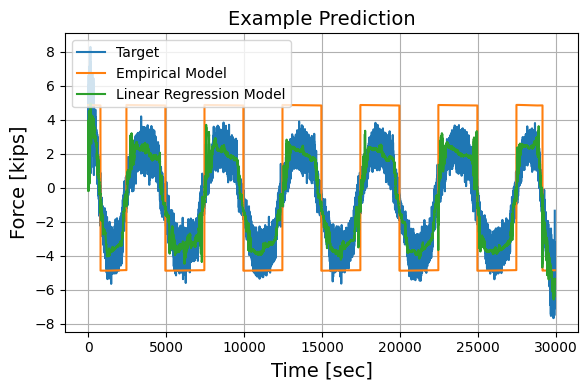

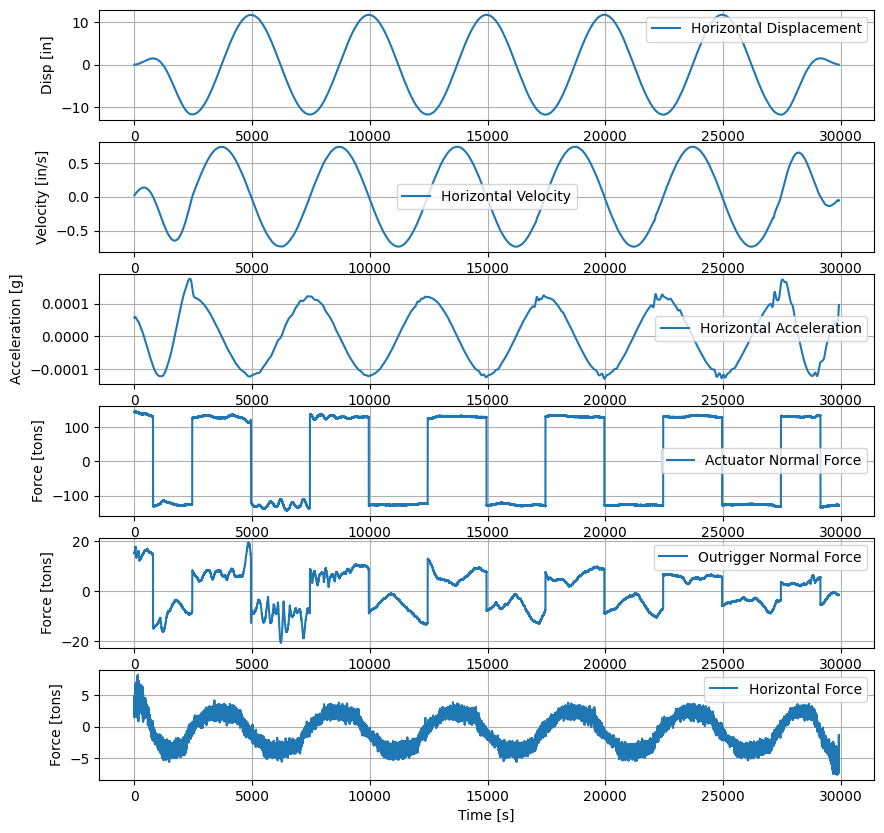

In [ ]:
prediction, empirical_prediction, signals, run_name = data[73]
time = np.arange(0,len(signals))

# target and prediction plot
post_process.plot_prediction(time, signals,empirical_prediction,prediction, run_name, model_name = 'PINN Model')
post_process.plot_signals(signals, time)

## 6. Conclusions <a class="anchor" id="sixth-bullet">
Description...